In [11]:
!pip install --upgrade qiskit

In [12]:
!pip install --upgrade qiskit networkx matplotlib numpy
!pip install qiskit-aer --upgrade
!pip install --upgrade qiskit qiskit-aer qiskit-optimization

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [13]:
import qiskit
print("Qiskit version:", qiskit.__version__)

Qiskit version: 2.2.2


In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit_aer import Aer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import GroverOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
np.random.seed(101)
import random
random.seed(101)

Enter number of nodes:  4
Enter name of node 1:  A
Enter name of node 2:  B
Enter name of node 3:  C
Enter name of node 4:  D
Enter number of edges:  5


Enter edges with attributes (node1 node2 distance energy traffic):


 A B 12 1 1
 A C 13 2 2 
 B C 10 3 3
 C D 9 4 4
 B D 5 5 5 


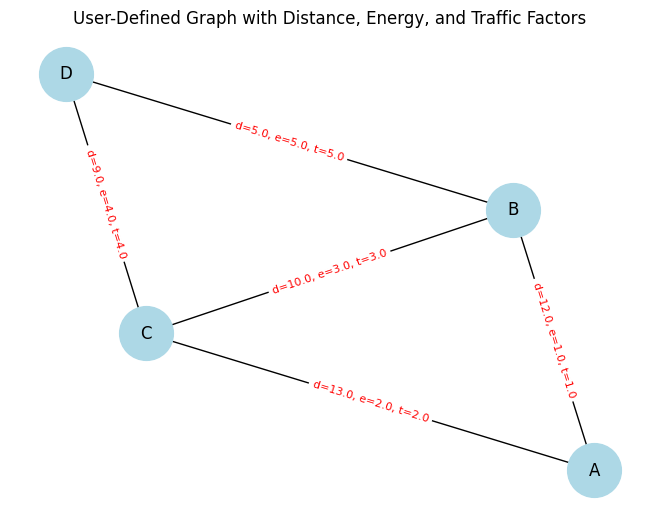

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Step 1: Read number of nodes
num_nodes = int(input("Enter number of nodes: "))

# Step 2: Read node names
nodes = []
for i in range(num_nodes):
    name = input(f"Enter name of node {i+1}: ")
    nodes.append(name)
G.add_nodes_from(nodes)

# Step 3: Read number of edges
num_edges = int(input("Enter number of edges: "))

# Step 4: Read edges and their attributes (distance, energy, traffic)
print("Enter edges with attributes (node1 node2 distance energy traffic):")
for _ in range(num_edges):
    line = input().split()
    if len(line) != 5:
        print("Invalid input, please enter exactly 5 values per edge")
        continue
    n1, n2 = line[0], line[1]
    distance, energy, traffic = map(float, line[2:])
    G.add_edge(n1, n2, distance=distance, energy=energy, traffic=traffic)

# Step 5: Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=12)

# Draw edge labels
edge_labels = {(u,v): f"d={d['distance']}, e={d['energy']}, t={d['traffic']}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("User-Defined Graph with Distance, Energy, and Traffic Factors")
plt.show()



Enter distance threshold to prune (keep only those with distance <= threshold):  20
Enter source node:  A
Enter target node:  B


Valid paths (distance ≤ 20.0 for all segments):
['A', 'B']
['A', 'C', 'B']
['A', 'C', 'D', 'B']


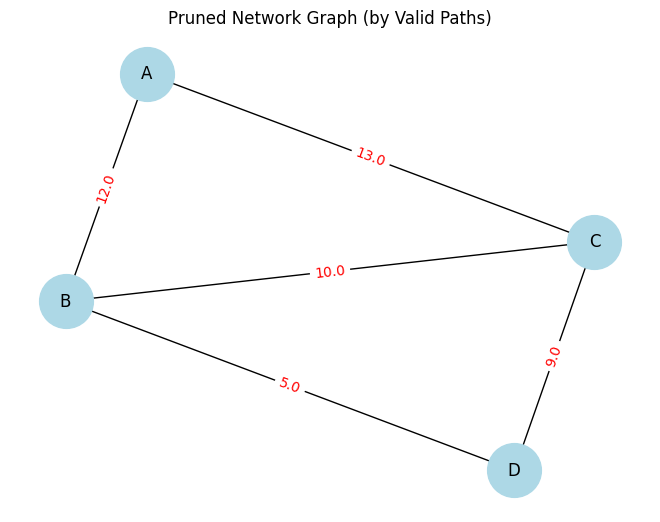

In [28]:
# PRUNING

# Step 1: Get distance threshold and source/destination
distance_threshold = float(input("\nEnter distance threshold to prune (keep only those with distance <= threshold): "))
source = input("Enter source node: ")
target = input("Enter target node: ")

# Step 2: Find all simple paths from source to target
all_paths = list(nx.all_simple_paths(G, source=source, target=target))

# Step 3: Collect only the path edges that meet the distance threshold
valid_paths = []
for path in all_paths:
    path_is_valid = True
    for i in range(len(path) - 1):
        # Check distance on each edge in this path
        if G[path[i]][path[i+1]]['distance'] > distance_threshold:
            path_is_valid = False
            break
    if path_is_valid:
        valid_paths.append(path)

# Optional: Construct a new pruned subgraph with only valid path edges
edges_in_valid_paths = set()
for path in valid_paths:
    for i in range(len(path) - 1):
        edges_in_valid_paths.add((path[i], path[i+1]))

pruned_graph = nx.Graph()
pruned_graph.add_nodes_from(G.nodes(data=True))
for u, v in edges_in_valid_paths:
    pruned_graph.add_edge(u, v, **G[u][v])

# Visualize pruned graph
if valid_paths:
    print(f"Valid paths (distance ≤ {distance_threshold} for all segments):")
    for path in valid_paths:
        print(path)
    pos = nx.spring_layout(pruned_graph)
    nx.draw(pruned_graph, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=12)
    edge_labels = {(u, v): f"{pruned_graph[u][v]['distance']}" for u, v in pruned_graph.edges()}
    nx.draw_networkx_edge_labels(pruned_graph, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Pruned Network Graph (by Valid Paths)")
    plt.show()
else:
    print(f"No valid paths exist between {source} and {target} with distance ≤ {distance_threshold}.")


In [29]:
#TOP-K SELECTION
# Default weights for eco cost formula
alpha = 1
beta = 1
gamma = 1

# Find all simple paths from source to target
routes = list(nx.all_simple_paths(G, source=source, target=target))

print(f"\nAll routes from {source} to {target}:")
for path in routes:
    eco_cost = 0
    for i in range(len(path) - 1):
        attrs = G[path[i]][path[i+1]]
        eco_cost += alpha * attrs['distance'] + beta * attrs['energy'] + gamma * attrs['traffic']
    print(f"Path: {path}, Eco Cost: {eco_cost}")



All routes from A to B:
Path: ['A', 'B'], Eco Cost: 14.0
Path: ['A', 'C', 'B'], Eco Cost: 33.0
Path: ['A', 'C', 'D', 'B'], Eco Cost: 49.0


In [30]:
#calculating no of qubits
import math

# 'routes' is your list of paths already computed:
# routes = list(nx.all_simple_paths(G, source=source, target=target))

num_routes = len(routes)
num_qubits = math.ceil(math.log2(num_routes))

print(f"Number of routes: {num_routes}")
print(f"Number of qubits needed: {num_qubits}")

route_encodings = []
for idx, route in enumerate(routes):
    state = format(idx, f"0{num_qubits}b")  # binary string
    route_encodings.append((route, state))

print("\nQuantum state assignments:")
for route, state in route_encodings:
    print(f"Route: {route} --> |{state}⟩ quantum basis state")


Number of routes: 3
Number of qubits needed: 2

Quantum state assignments:
Route: ['A', 'B'] --> |00⟩ quantum basis state
Route: ['A', 'C', 'B'] --> |01⟩ quantum basis state
Route: ['A', 'C', 'D', 'B'] --> |10⟩ quantum basis state


In [31]:
import numpy as np
import random
import math
import time
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Seed RNGs
np.random.seed(101)
random.seed(101)

# Assuming G and route_encodings are properly defined above
# Also alpha, beta, gamma weights:

alpha = 1
beta = 1
gamma = 1

# Compute eco_costs:
eco_costs = []
for route, _ in route_encodings:
    eco_cost = 0
    for i in range(len(route) - 1):
        attrs = G[route[i]][route[i+1]]
        eco_cost += alpha * attrs['distance'] + beta * attrs['energy'] + gamma * attrs['traffic']
    eco_costs.append(eco_cost)

min_cost = min(eco_costs)
winning_states = [state for (route, state), cost in zip(route_encodings, eco_costs) if cost == min_cost]

num_qubits = max(1, math.ceil(math.log2(len(route_encodings))))

def oracle(circuit, winner_states, num_qubits):
    for w_state in winner_states:
        for i, bit in enumerate(w_state):
            if bit == '0':
                circuit.x(i)
        circuit.h(num_qubits - 1)
        if num_qubits == 1:
            circuit.z(0)
        elif num_qubits == 2:
            circuit.cz(0, 1)
        else:
            circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        circuit.h(num_qubits - 1)
        for i, bit in enumerate(w_state):
            if bit == '0':
                circuit.x(i)

def diffuser(circuit, num_qubits):
    for q in range(num_qubits):
        circuit.h(q)
    for q in range(num_qubits):
        circuit.x(q)
    circuit.h(num_qubits - 1)
    if num_qubits == 1:
        circuit.z(0)
    elif num_qubits == 2:
        circuit.cz(0, 1)
    else:
        circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)
    for q in range(num_qubits):
        circuit.x(q)
    for q in range(num_qubits):
        circuit.h(q)

# Build Grover circuit
grover_circuit = QuantumCircuit(num_qubits, num_qubits)
for q in range(num_qubits):
    grover_circuit.h(q)  # Correct Hadamard application

iterations = max(1, int(math.pi / 4 * math.sqrt(2**num_qubits)))

for _ in range(iterations):
    oracle(grover_circuit, winning_states, num_qubits)
    diffuser(grover_circuit, num_qubits)

grover_circuit.measure(range(num_qubits), range(num_qubits))

simulator = AerSimulator()
start_quantum_time = time.time()
job = simulator.run(grover_circuit, shots=1024, seed_simulator=101)
result = job.result()
end_quantum_time = time.time()

counts = result.get_counts()
print("Grover results:", counts)
plot_histogram(counts)

best_state = max(counts, key=counts.get)
best_route = None
for route, state in route_encodings:
    if state == best_state:
        best_route = route
        break

print(f"Optimized route found: {best_route} with quantum state |{best_state}>")
print(f"Quantum execution time: {end_quantum_time - start_quantum_time:.6f} seconds")


Grover results: {'01': 249, '00': 275, '10': 270, '11': 230}
Optimized route found: ['A', 'B'] with quantum state |00>
Quantum execution time: 0.009805 seconds
